# Compare `q2-feature-classifier` and `rdp-classifier`

### Setup

In [1]:
import csv
from itertools import product
from collections import defaultdict, Counter

from qiime import Artifact
from q2_types import DNAIterator
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image

### Load the results

In [2]:
seqs = Artifact.load('iceland/fmt-tutorial-rep-seqs.qza')
seq_names = [s.metadata['id'] for s in seqs.view(DNAIterator)]
levels = ('kingdom', 'phylum', 'class', 'order', 'family',
          'genus', 'species')

In [3]:
def emptytaxon():
    return {l:'' for l in levels}
rdp = defaultdict(lambda: defaultdict(emptytaxon))
nb = defaultdict(lambda: defaultdict(emptytaxon))
for confidence in range(0,101,5):
    filename = 'iceland/nb/fmt-tutorial-classification-c-%03d.qza' % confidence
    df = Artifact.load(filename).view(DataFrame)
    for ix in df.index:
        nb[confidence][ix].update(zip(levels, df['Taxon'][ix].split('; ')))
        
    filename = 'iceland/rdp/rdp-%03d/rep_seq_tax_assignments.txt' % confidence
    with open(filename) as taxass:
        reader = csv.reader(taxass, delimiter='\t')
        for row in reader:
            rdp[confidence][row[0]].update(zip(levels, row[1].split(';')))

### Plot some comparisons

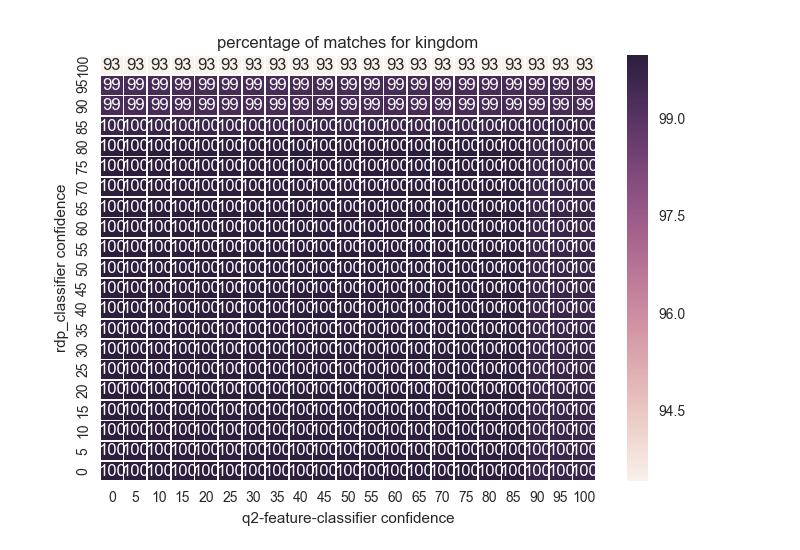

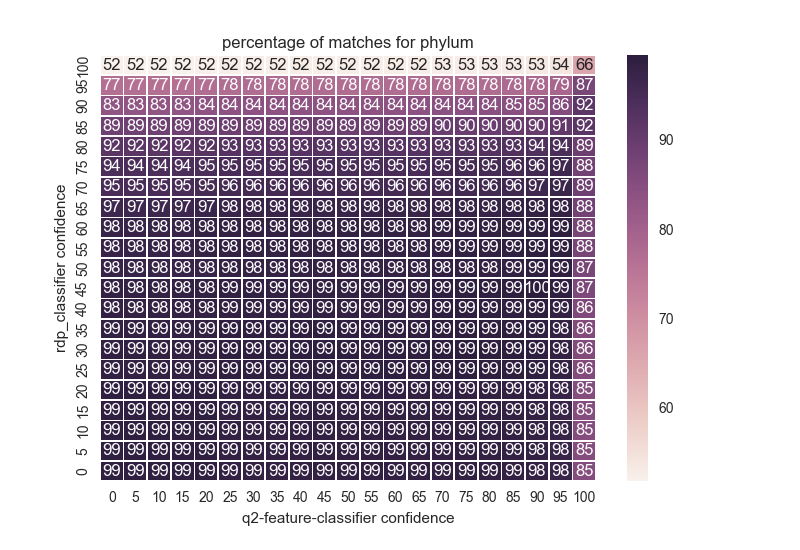

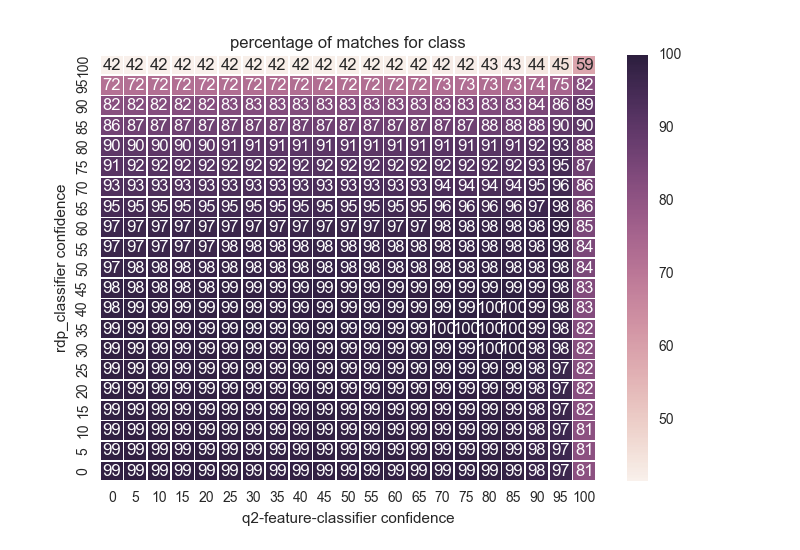

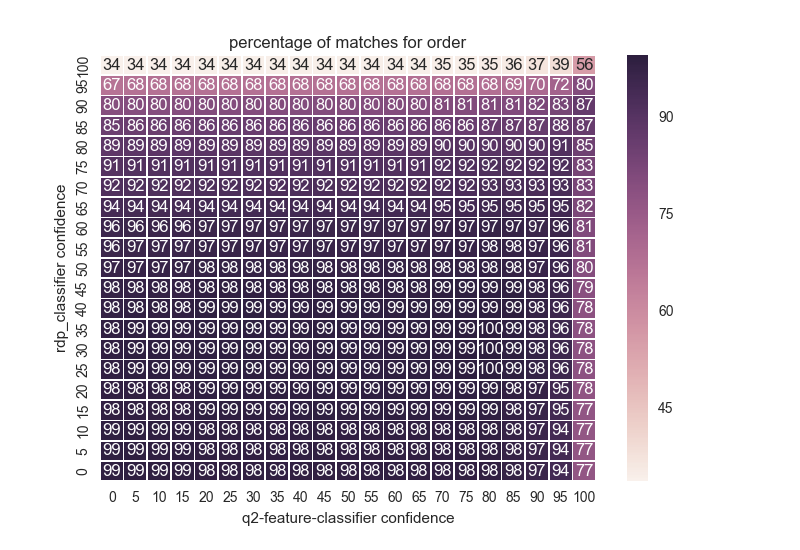

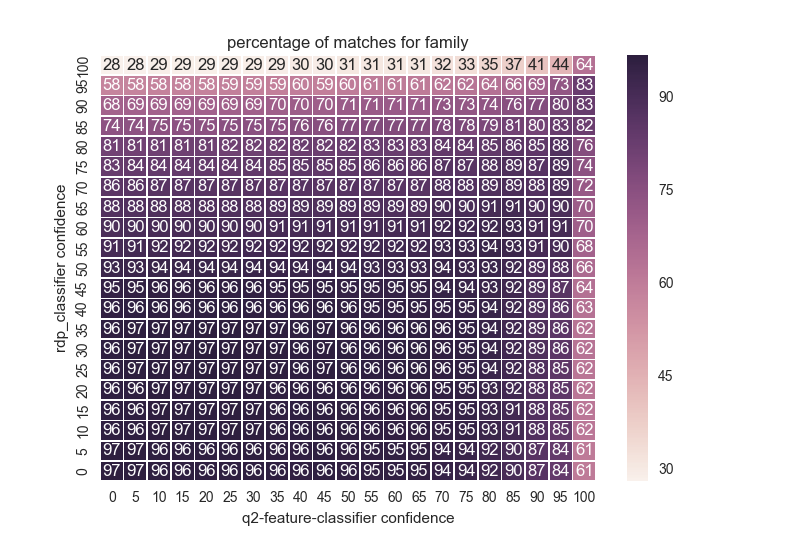

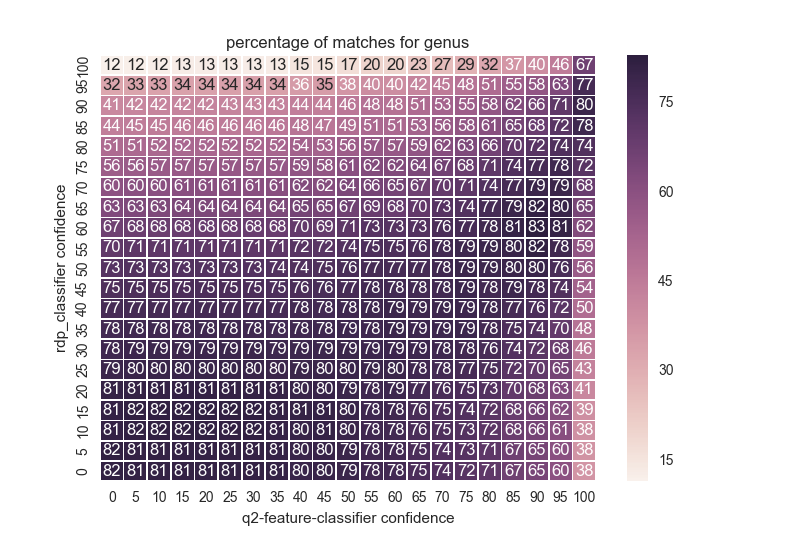

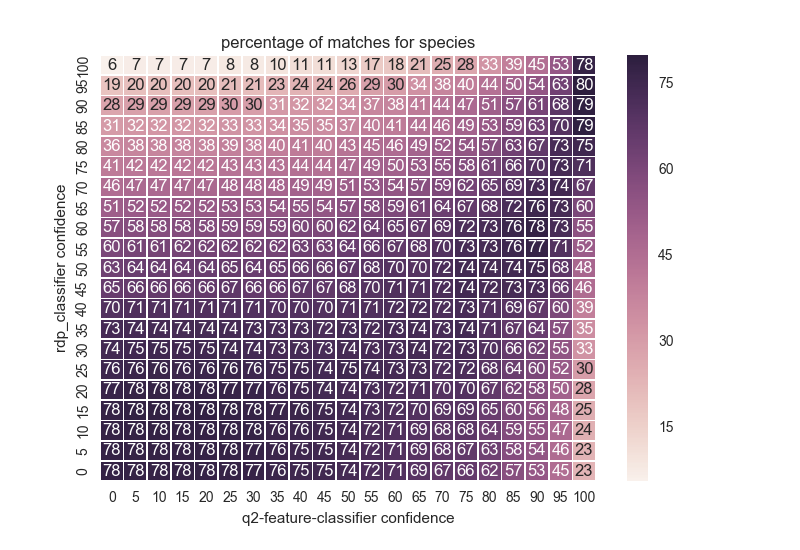

In [4]:
sns.set()
for level in levels:
    matches = defaultdict(Counter)
    for i,j in product(*[range(0,101,5)]*2):
        for label in seq_names:
            nb_taxon = nb[i][label][level]
            rdp_taxon = rdp[j][label][level]
            if nb_taxon == rdp_taxon:
                matches[i][j] += 1
    matches = DataFrame(matches)/len(seq_names)*100
    matches.index.name = 'rdp_classifier confidence'
    matches.columns.name = 'q2-feature-classifier confidence'
    plt.clf()
    ax = sns.heatmap(matches, annot=True, fmt='.0f', linewidths=.5)
    ax.invert_yaxis()
    ax.set_title('percentage of matches for ' + level)
    fig = ax.get_figure()
    figname = 'iceland/plots/' + level + '.png'
    fig.savefig(figname)
    display(Image(figname))